In [ ]:
!wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
!chmod +x Anaconda3-5.1.0-Linux-x86_64.sh
!bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local
!conda install -q -y --prefix /usr/local -c pytorch -c tensorcomp tensor_comprehensions

import sys
sys.path.append('/usr/local/lib/python3.6/site-packages/')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics

In [4]:
df = pd.read_csv("/content/drive/MyDrive/car_dekho/car data.csv")
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [5]:
df.shape

(301, 9)

In [6]:
print(df["Fuel_Type"].unique())
print(df["Seller_Type"].unique())
print(df["Transmission"].unique())
print(df["Owner"].unique())

['Petrol' 'Diesel' 'CNG']
['Dealer' 'Individual']
['Manual' 'Automatic']
[0 1 3]


In [7]:
#check missing or null value
df.isnull().sum()

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

In [8]:
df.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [9]:
df.columns

Index(['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Kms_Driven',
       'Fuel_Type', 'Seller_Type', 'Transmission', 'Owner'],
      dtype='object')

In [10]:
final_df = df[['Year', 'Selling_Price', 'Present_Price', 'Kms_Driven',
       'Fuel_Type', 'Seller_Type', 'Transmission', 'Owner']]
final_df
#cz car name isnt playing a huge role in predicting car price, instead selling price and present price plays imp role

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0
...,...,...,...,...,...,...,...,...
296,2016,9.50,11.60,33988,Diesel,Dealer,Manual,0
297,2015,4.00,5.90,60000,Petrol,Dealer,Manual,0
298,2009,3.35,11.00,87934,Petrol,Dealer,Manual,0
299,2017,11.50,12.50,9000,Diesel,Dealer,Manual,0


In [11]:
#to find how old our car is, to calculate depreciation value
#i.e current year - year when car was brought
final_df['current_year'] = 2020
final_df['no_of_years'] = final_df['current_year'] - final_df['Year']
final_df.head()

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,current_year,no_of_years
0,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0,2020,6
1,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0,2020,7
2,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0,2020,3
3,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0,2020,9
4,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0,2020,6


In [12]:
#now year and current year isnt required
final_df.drop((['Year', 'current_year']), axis=1, inplace=True) 


In [13]:
final_df.head()

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,no_of_years
0,3.35,5.59,27000,Petrol,Dealer,Manual,0,6
1,4.75,9.54,43000,Diesel,Dealer,Manual,0,7
2,7.25,9.85,6900,Petrol,Dealer,Manual,0,3
3,2.85,4.15,5200,Petrol,Dealer,Manual,0,9
4,4.60,6.87,42450,Diesel,Dealer,Manual,0,6


In [14]:
#we use get dummies function from pandas to convert categorical data to one hot encoded data
#converting to one hot encoding cz categorices of each features are less
# we use drop_first to avoid dummy varable trap
final_df = pd.get_dummies(final_df, drop_first = True)
final_df.head()

,Selling_Price,Present_Price,Kms_Driven,Owner,no_of_years,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,3.35,5.59,27000,0,6,0,1,0,1
1,4.75,9.54,43000,0,7,1,0,0,1
2,7.25,9.85,6900,0,3,0,1,0,1
3,2.85,4.15,5200,0,9,0,1,0,1
4,4.60,6.87,42450,0,6,1,0,0,1


In [15]:
#to find correlation between features
final_df.corr()

,Selling_Price,Present_Price,Kms_Driven,Owner,no_of_years,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
Selling_Price,1.000000,0.878983,0.029187,-0.088344,-0.236141,0.552339,-0.540571,-0.550724,-0.367128
Present_Price,0.878983,1.000000,0.203647,0.008057,0.047584,0.473306,-0.465244,-0.512030,-0.348715
Kms_Driven,0.029187,0.203647,1.000000,0.089216,0.524342,0.172515,-0.172874,-0.101419,-0.162510
Owner,-0.088344,0.008057,0.089216,1.000000,0.182104,-0.053469,0.055687,0.124269,-0.050316
no_of_years,-0.236141,0.047584,0.524342,0.182104,1.000000,-0.064315,0.059959,0.039896,-0.000394
Fuel_Type_Diesel,0.552339,0.473306,0.172515,-0.053469,-0.064315,1.000000,-0.979648,-0.350467,-0.098643
Fuel_Type_Petrol,-0.540571,-0.465244,-0.172874,0.055687,0.059959,-0.979648,1.000000,0.358321,0.091013
Seller_Type_Individual,-0.550724,-0.512030,-0.101419,0.124269,0.039896,-0.350467,0.358321,1.000000,0.063240
Transmission_Manual,-0.367128,-0.348715,-0.162510,-0.050316,-0.000394,-0.098643,0.091013,0.063240,1.000000


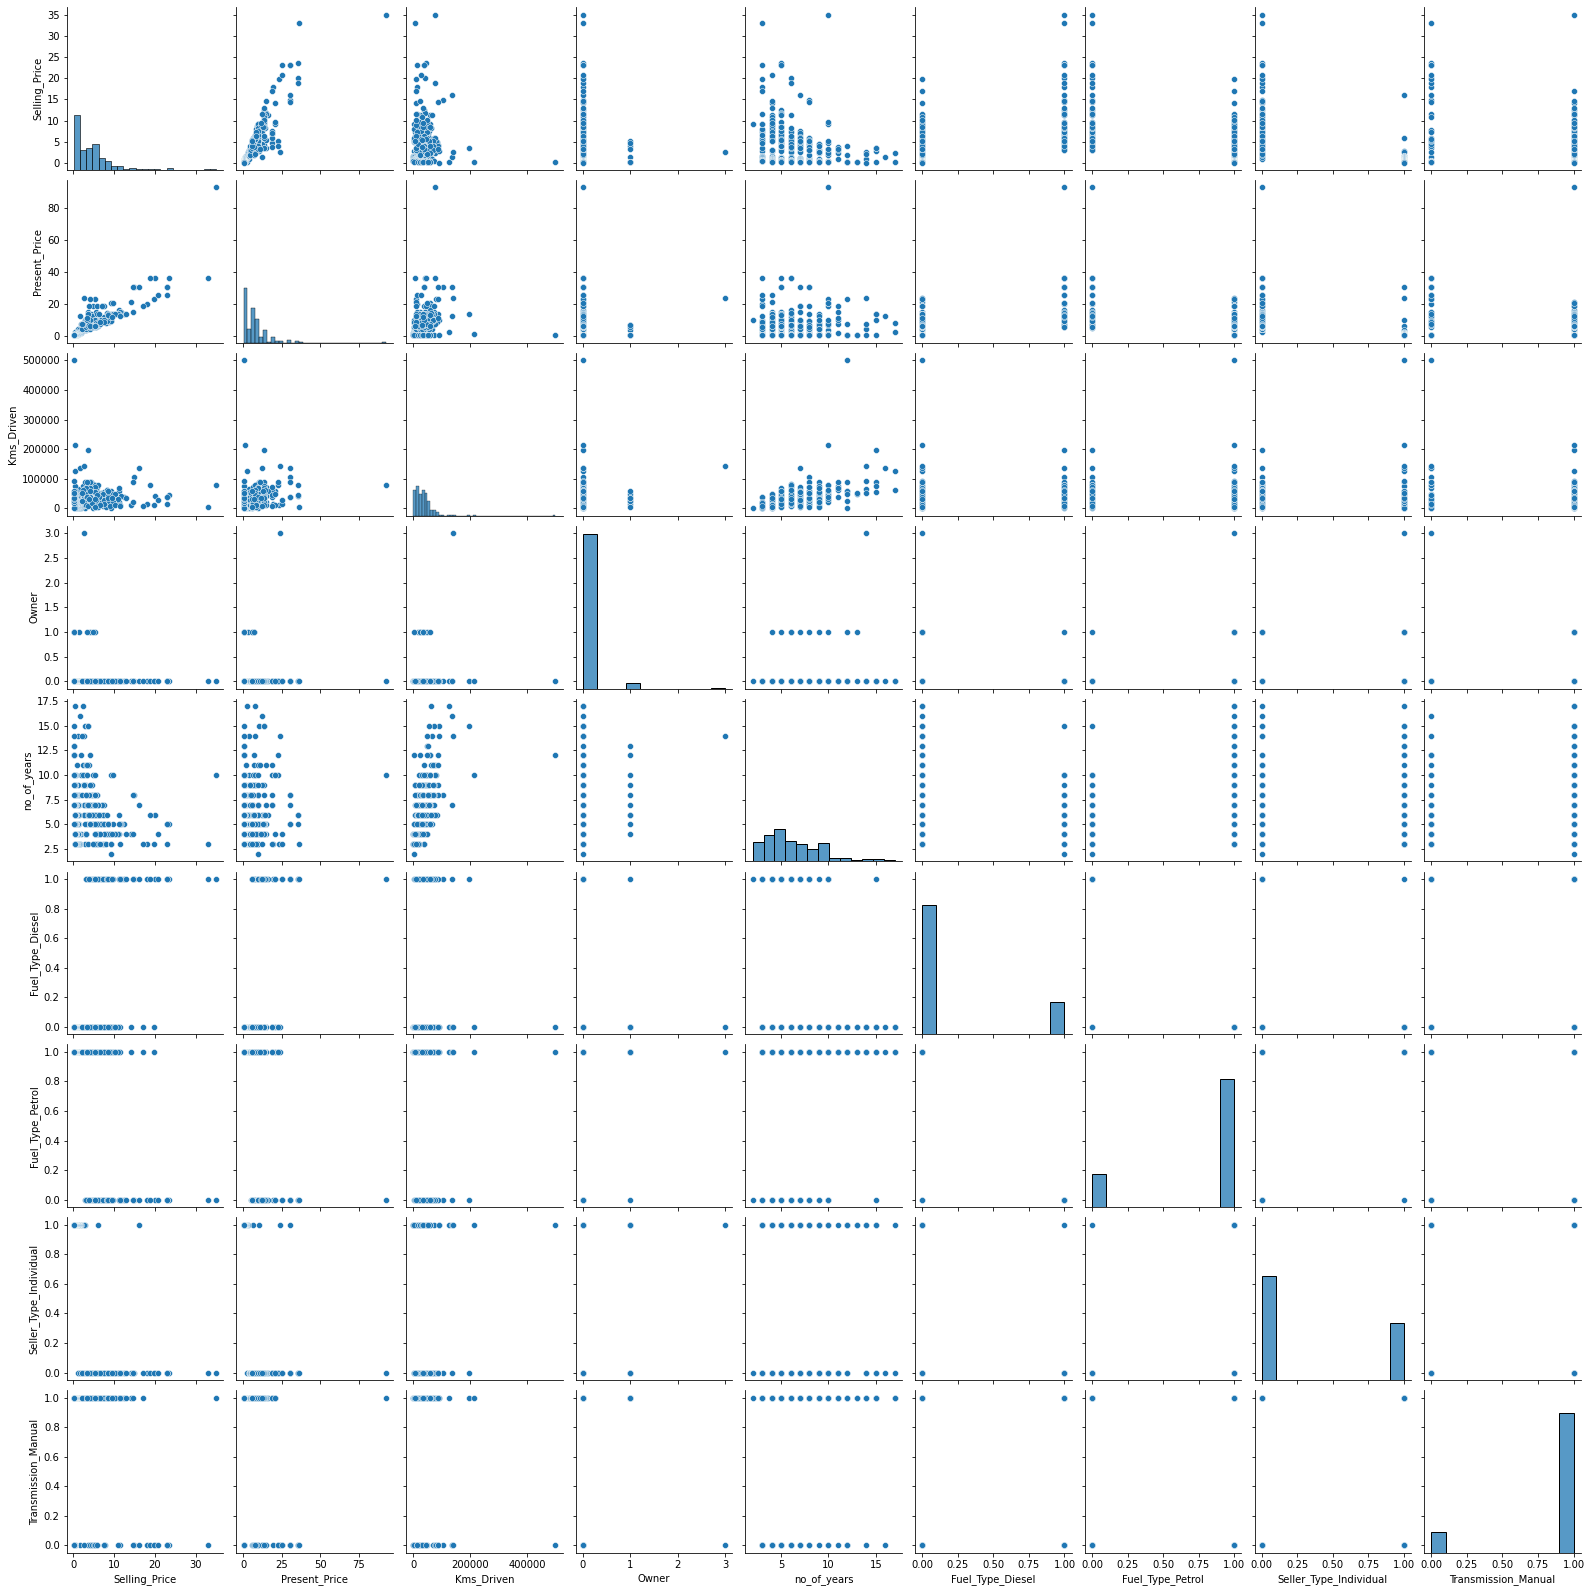

In [16]:
#diagrametical view of correlation of each feature with another
sns.pairplot(final_df)

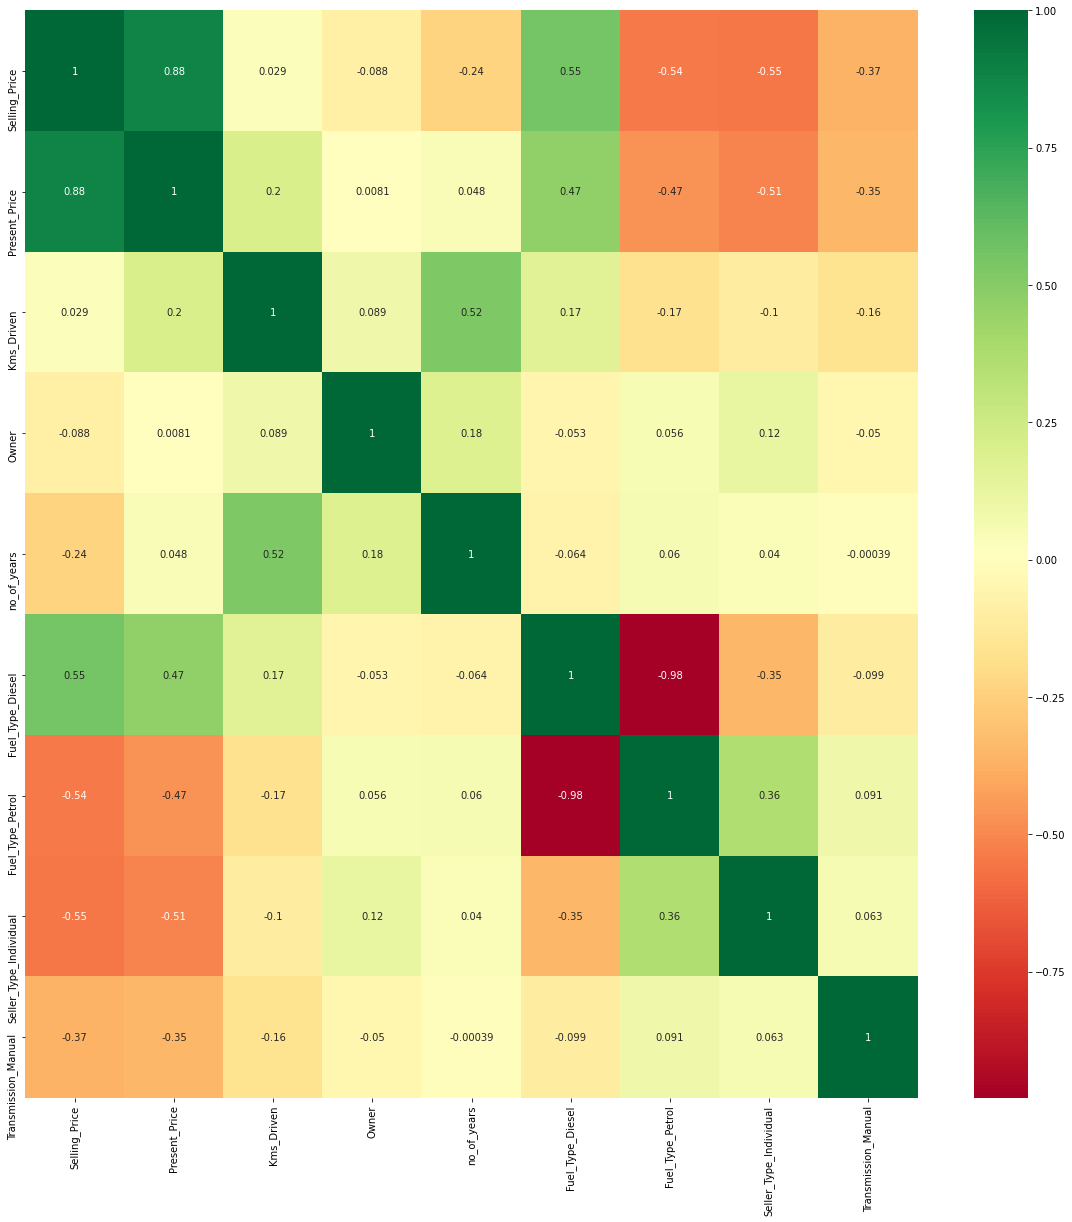

In [17]:
#since visualizing using so many figures is difficult, therfore we use heatmaps for better visulization
corrmap = final_df.corr()
top_corr_features = corrmap.index
plt.figure(figsize=(20,20))

#plot heatmap
g = sns.heatmap(final_df[top_corr_features].corr(),annot= True, cmap = "RdYlGn")
#annot =True to see the values, cmap style is RdYlGn

In [18]:
final_df.head()
#selling price is our y , that is dependent variable

,Selling_Price,Present_Price,Kms_Driven,Owner,no_of_years,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,3.35,5.59,27000,0,6,0,1,0,1
1,4.75,9.54,43000,0,7,1,0,0,1
2,7.25,9.85,6900,0,3,0,1,0,1
3,2.85,4.15,5200,0,9,0,1,0,1
4,4.60,6.87,42450,0,6,1,0,0,1


In [19]:
X = final_df.iloc[:,1:] #independent features
y = final_df.iloc[:,0]  #dependent features

In [20]:
X.head()

,Present_Price,Kms_Driven,Owner,no_of_years,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,5.59,27000,0,6,0,1,0,1
1,9.54,43000,0,7,1,0,0,1
2,9.85,6900,0,3,0,1,0,1
3,4.15,5200,0,9,0,1,0,1
4,6.87,42450,0,6,1,0,0,1


In [21]:
y.head()

0    3.35
1    4.75
2    7.25
3    2.85
4    4.60
Name: Selling_Price, dtype: float64

In [22]:
###feature importance using sklearn if we have many features and since its a regressor problem we use ExtraTreesRegressor
model = ExtraTreesRegressor()
model.fit(X,y)
print(model.feature_importances_)

[0.39166934 0.04345997 0.00124642 0.07666143 0.22061671 0.01601343
 0.12176413 0.12856857]


# we can see present_price has highest feature importance

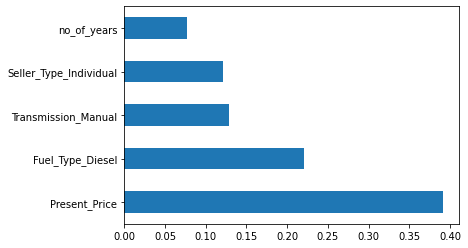

In [23]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns) 
feat_importances.nlargest(5).plot(kind='barh') 
plt.show()

In [24]:
#train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)
X_train.shape

(240, 8)

In [25]:
#Randomized Search CV

###hperparameters
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]


In [26]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


In [27]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

In [28]:

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [29]:
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   1.5s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   1.5s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   1.5s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   1.5s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   1.5s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15 
[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, total=   1.8s
[CV] n_estimators=1100, min_samples_split=10, mi

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [30]:
rf_random.best_params_

{'max_depth': 25,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [31]:
rf_random.best_score_

-1.9739021998270048

In [32]:
predictions = rf_random.predict(X_test)

In [33]:
print(predictions)

[ 2.35609     4.81108     5.66724     3.40764    14.87474     5.07755
  5.23832     0.52689     1.25775     9.08885     0.31446     8.84232
  0.53232     5.35482     8.5148      8.02534     0.85644     5.57313333
  2.39126     0.98858     5.14645     0.57521    18.86819     5.20031
  4.68845     6.47927     1.04859     3.12661     9.43563     4.42975
  0.99268    12.49474     1.34904     2.91616     4.25648     3.81127
  3.10806     0.59313     0.2273     10.6401      6.7137      6.17849333
  4.267       0.38473    18.53021     0.54235     4.8289      0.97848
  2.60402     0.29131    18.53021     7.68597     0.5989      6.46644
 17.53991     0.56744     3.73844     1.13292     0.79567     0.81711
  8.01112   ]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


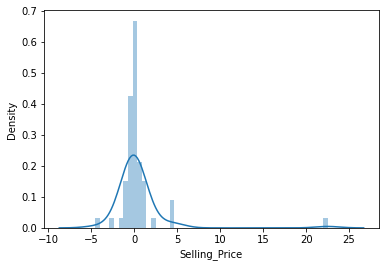

In [34]:
# to compare y_test values with predicted values
sns.distplot(y_test - predictions)

#by graph we can see that the dist is normal dist which means our predicton is pretty good

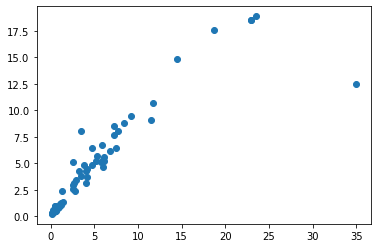

In [35]:
plt.scatter(y_test,predictions)

#plot is also linear, meaning our predicton is pretty good

In [36]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 1.1297657923497217
MSE: 10.16723803302776
RMSE: 3.1886106744204064


In [71]:

import pickle
# open a file, where you ant to store the data
file = open('/content/drive/MyDrive/car_dekho/random_forest_regression_model.pkl', 'wb')

# dump information to that file
pickle.dump(rf_random, file)

In [74]:
#create requirement.txt file for deployment
#generate reuirement.txt fil, search in google(should do it locally)
# https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html
# go to conda promt: 1. conda create -n carprediction python=3.7
# 2. activate carprediction

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [ ]:
!pip freeze > requirements.txt